In [57]:
import qutip as q
import numpy as np
from matplotlib import pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact, interactive
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
import ffmpeg

from wigner import rho_to_wig, plot_wigner


## Coupling a two-level system to an EM field in a cavity 
$H = \hbar\frac{\omega_a}{2}\sigma_z + \hbar\omega_c a^\dagger a + \hbar\frac{\Omega}{2}(\sigma_+ a + \sigma_- a^\dagger)$ where $\sigma_+ = |e\rangle\langle g|$, $\sigma_- = |g\rangle\langle e|$. 

In [84]:
N = 50
hbar = 1
pi = np.pi
oma = pi/2
omc = pi/2
Om = pi
#alpha = 0

sz = q.tensor(q.sigmaz(), q.identity(N))
ad = q.tensor(q.identity(2), q.create(N))
a = q.tensor(q.identity(2), q.destroy(N))
sm = q.tensor(q.sigmam(), q.identity(N))
sp = q.tensor(q.sigmap(), q.identity(N))

def qed_solver(oma, omc, Om, gamma=0, alpha = 0, zeta = 0, t = np.linspace(0,20,401)):

    H = hbar*oma/2*sz + hbar*omc*ad*a + hbar*Om/2*(sp*a + sm*ad)

    if gamma > 0:
        c_ops = [np.sqrt(gamma) * sm]
    else:
        c_ops = []
    
    #Initial state (squeeze the coherent state)
    rho0 = q.tensor(q.basis(2,0), q.squeeze(N, zeta) @ q.coherent(N, alpha))
    #rho0 = q.tensor(q.basis(2,0), q.squeeze(N, 0.5))
    
    res = q.mesolve(H, rho0, c_ops = c_ops,tlist= t)

    return res


def plot_evolution(oma = oma, omc = omc, Om= Om,gamma = 0,alpha=0, zeta = 0):

    res = qed_solver(oma,omc,Om,gamma,alpha,zeta)
    
    plt.plot(res.times, [q.expect(ad*a, s) for s in res.states], label ='cavity photon number')
    plt.xlabel(r'Time, $t$')
    plt.ylabel(r'$\langle\hat{a}^\dagger \hat{a}\rangle$')

In [85]:
interact(plot_evolution, oma =(0,pi,0.01), 
         omc =(0,pi,0.01), 
         Om =(0,pi,0.01), 
         gamma=(0,1,0.01), 
         alpha=(0,2,0.01),
        zeta = (0,1,0.01))

interactive(children=(FloatSlider(value=1.5707963267948966, description='oma', max=3.141592653589793, step=0.0…

<function __main__.plot_evolution(oma=1.5707963267948966, omc=1.5707963267948966, Om=3.141592653589793, gamma=0, alpha=0, zeta=0)>

In [86]:
def plot_cavity_evolution(oma = oma, omc = omc, Om= Om,gamma = 0,alpha=0, zeta = 0,x = np.linspace(-5,5,50), N=N):
    ims = []
    res = qed_solver(oma,omc,Om,gamma,alpha,zeta)
    fig, axes = plt.subplots(1, 2, figsize = (8,4))

    axes[0].plot(res.times, [q.expect(ad*a, s) for s in res.states], linestyle = 'dashed', label ='cavity photon number')
    axes[0].set_xlabel(r'Time, $t$')
    axes[0].set_ylabel(r'$\langle\hat{a}^\dagger \hat{a}\rangle$')
    axes[0].legend()
    

    for i, s in enumerate(res.states): 

        rho_cavity = s.ptrace(1)
        x = np.linspace(-5,5,50)
        W_cavity = q.wigner(rho_cavity, x,x)
        #W_cavity = rho_to_wig(rho_cavity, x, x, N)
        im1 = axes[0].scatter(res.times[i], q.expect(ad*a,s), color = 'b')
        
        im2 = plot_wigner(axes[1], W_cavity, x, x)
        
        ims.append([im1,im2])

    return ArtistAnimation(fig, ims, interval=50, blit=True)

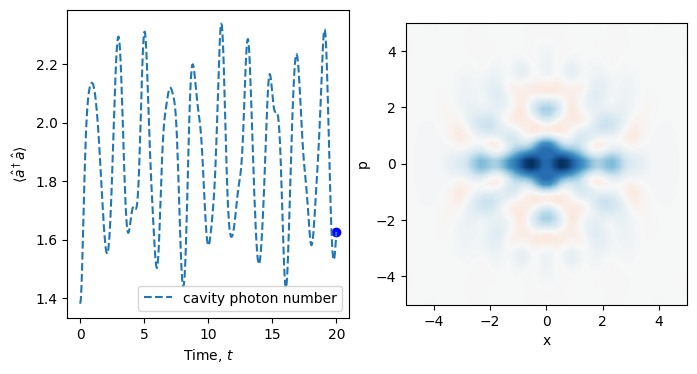

In [88]:
ani = plot_cavity_evolution(gamma = 0, alpha = 0, zeta = 1)
HTML(ani.to_html5_video())
    

In [43]:
ani.save('squeezed_cavity.mp4')